In [95]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import keras.backend as K

from lib.utils import load_gtsrb

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(1234)

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, :, :, np.newaxis] / 255.
X_test = X_test[:, :, :, np.newaxis] / 255.
# y_train = y_train[:, np.newaxis]
# y_test = y_test[:, np.newaxis]
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.1)

In [51]:
def find_nn(Q, X, k):
    assert Q.shape[1:] == X.shape[1:]
    nn = np.zeros((len(Q), k), dtype=np.int32)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    for i, q in enumerate(Q):
        ind = np.argsort(np.sum((X - q)**2, axis=axis))[:k]
        nn[i] = ind
    return nn


def classify(nn, y_X):
    vote = np.array([np.argmax(np.bincount(y)) for y in y_X[nn]])
    return vote


def find_acc(nn, y_Q, y_X):
    vote = classify(nn, y_X)
    print(np.mean(vote == y_Q))
    
    
def find_nn_diff_class(Q, y_Q, X, y_X, k):
    target = np.zeros((len(Q), k), dtype=np.int32)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    for i, (q, y_q) in enumerate(zip(Q, y_Q)):
        ind = np.argsort(np.sum((X - q)**2, axis=axis))
        target[i] = ind[y_X[ind] != y_q][:k]
    return target


def move_to_target(q, y_q, target, X, y_X, k, n_steps=5):
    """
    Move in straight line to target with binary search.
    Stop when adv is misclassified.
    """
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    line = target - q
    hi = 1
    lo = 0
    adv = None
    for step in range(n_steps):
        mid = (hi + lo)/2
        x_new = mid*line + q
        new_neighbors = np.argsort(np.sum((X - x_new)**2, axis=axis))[:k]
        y_pred = np.argmax(np.bincount(y_X[new_neighbors]))
        if y_pred == y_q:
            lo = mid
        else:
            hi = mid
            adv = x_new
    return adv
            
    
def attack_v2(Q, y_Q, X, y_X, k, n_steps=5):
    """
    Naive attack v2 (untargeted): 
    Complexity is O(k * n_X log (n_X) * n_Q * n_steps)
    
    1. Choose trianing sample of target class from X closest to query
    2. Find closest sample of the same class to the mean of K
    3. Add that sample to K
    4. Repeat 2. - 3. until |K| = k/2 + 1
    5. Move query closer to mean of K, terminate when query becomes
       adversarial
    """
    
    nn = find_nn_diff_class(Q, y_Q, X, y_X, 1)
    X_adv = np.zeros_like(Q)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    
    for i, (q, y_q) in enumerate(zip(Q, y_Q)):
        
        if i % 200 == 0:
            print(i)
        
        n_neighbors = int(np.floor(k/2) + 1)
        K = np.zeros((n_neighbors, ) + Q.shape[1:])
                    
        # Step 1.
        K[0] = X[nn[i, 0]]
        K_ind = [nn[i, 0]]

        for j in range(1, n_neighbors):
            
            # Step 2.
            mean = np.mean(K[:j], axis=0)
            ind = np.argsort(np.sum((X - mean)**2, axis=axis))
            new_nbs = ind[y_X[ind] != y_q]
            
            # Step 3.
            for new_nb in new_nbs:
                if new_nb not in K_ind:
                    K_ind.append(new_nb)
                    K[j] = X[new_nb]
                    break
                    
        # Step 5.
        mean = np.mean(K, axis=0)
        X_adv[i] = move_to_target(q, y_q, mean, X, y_X, k, n_steps)
        
    return X_adv


def attack_v3(Q, y_Q, X, y_X, k, n_repeats=100, n_steps=5):
    """
    Naive attack v2 (untargeted): greeedy
    Complexity is O(n_repeats * k * n_X * n_Q)
    
    1. Choose trianing sample of target class from X closest to query
    2. Find closest sample of the same class to the mean of K
    3. Add that sample to K
    4. Repeat 2. - 3. until |K| = k/2 + 1
    5. Move query closer to mean of K, terminate when query becomes
       adversarial
    6. Repeat 1. - 5. for n_repeats times
    """
    
    nn = find_nn_diff_class(Q, y_Q, X, y_X, 1)
    X_adv = np.zeros_like(Q)
    
    for i, (q, y_q) in enumerate(zip(Q, y_Q)):
        
        n_neighbors = int(np.floor(k/2) + 1)
        K = np.zeros((n_neighbors, ) + Q.shape[1:])
        best_dist = 1e9
        best_adv = None
        
        for _ in range(n_repeats):
            
            # Step 1.
            K[0] = X[nn[i, 0]]
            
            for j in range(1, n_neighbors):
                
                # Step 2.
                mean = np.mean(K[:j])
                ind = np.argsort(np.sum((X - mean)**2, axis=(1, 2, 3)))
                new_nb = ind[y_X[ind] != y_q][0]
                
                # Step 3.
                K[j] = X[new_nb]
                
            # Step 5.
            mean = np.mean(K)
            adv = move_to_target(q, y_q, mean, X, y_X, k, n_steps)
            if adv is not None:
                dist = np.sqrt(np.sum((adv - q)**2))
                if dist < best_dist:
                    best_dist = dist
                    best_adv = adv
            
        X_adv[i] = best_adv
        
    return X_adv

## One NN with two classes

In [4]:
k = 1

X_3 = X_train[y_train == 3]
X_7 = X_train[y_train == 7]
X_37 = X_train[(y_train == 3) | (y_train == 7)]
y_37 = y_train[(y_train == 3) | (y_train == 7)]
X_37_test = X_test[(y_test == 3) | (y_test == 7)]
y_37_test = y_test[(y_test == 3) | (y_test == 7)]

In [ ]:
nn = np.zeros((len(X_37_test,)), dtype=np.int32)
for i, x in enumerate(X_37_test):
    ind = np.argmin(np.sum((X_37 - x)**2, axis=(1, 2, 3)))
    nn[i] = ind

In [19]:
np.mean(y_37[nn] == y_37_test)

0.9946025515210991

Trivial attack for k = 1.  
1) Find closest sample of target class  
2) Do a line search on the line between a sample and its closest sample of target class

In [21]:
target = np.zeros((len(X_37_test,)), dtype=np.int32)
for i, (x, y) in enumerate(zip(X_37_test, y_37_test)):
    ind = np.argsort(np.sum((X_37 - x)**2, axis=(1, 2, 3)))
    target[i] = ind[y_37[ind] != y_37_test[i]][0]

In [46]:
n_steps = 5
adv = np.zeros_like(X_37_test)

for i, (x, y) in enumerate(zip(X_37_test, y_37_test)):
    if i % 1000 == 0:
        print(i)
    line = X_37[target[i]] - x
    hi = 1
    lo = 0
    for step in range(n_steps):
        mid = (hi + lo)/2
        x_new = mid * line + x
        new_neighbor = np.argmin(np.sum((X_37 - x_new)**2, axis=(1, 2, 3)))
        if y_37[new_neighbor] == y:
            lo = mid
        else:
            hi = mid
            adv[i] = x_new

0
1000
2000


In [47]:
nn_adv = np.zeros((len(X_37_test,)), dtype=np.int32)
for i, x in enumerate(adv):
    ind = np.argmin(np.sum((X_37 - x)**2, axis=(1, 2, 3)))
    nn_adv[i] = ind

In [48]:
np.mean(y_37[nn_adv] == y_37_test)

0.0

In [49]:
dist = np.sqrt(np.sum((X_37_test - adv)**2, axis=(1, 2, 3)))
print(np.mean(dist))

3.001860962268607


In [38]:
dist = np.sqrt(np.sum((X_37_test - X_37[target])**2, axis=(1, 2, 3)))
print(np.mean(dist))

7.239598717944386


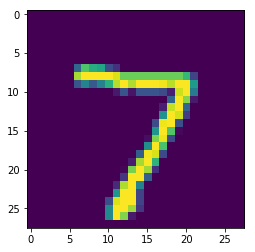

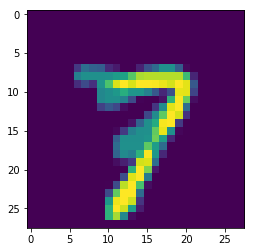

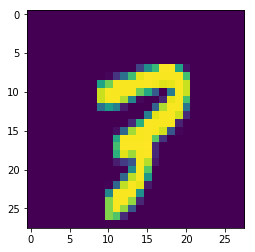

In [50]:
i = 0

plt.imshow(X_37_test[i, :, :, 0])
plt.show()
plt.imshow(adv[i, :, :, 0])
plt.show()
plt.imshow(X_37[nn_adv[i], :, :, 0])
plt.show()

---

## kNN with two classes

In [5]:
k = 3
nn = find_nn(X_37_test, X_37, k)
find_acc(nn, y_37_test, y_37)

0.9941118743866536


In [ ]:
X_adv = attack_v2(X_37_test, y_37_test, 
                  X_37, y_37, 
                  k, n_steps=5)

0
200
400
600
800
1000
1200
1400
1600


In [40]:
# Check if any is None
print(np.where(X_adv == None))

nn_adv = find_nn(X_adv, X_37, k)
find_acc(nn_adv, y_37_test, y_37)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
0.0


In [41]:
dist = np.sqrt(np.sum((X_37_test - X_adv)**2, axis=(1, 2, 3)))
print(np.mean(dist))

3.905456878324329


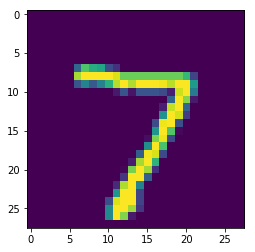

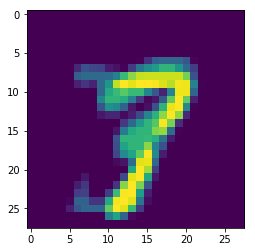

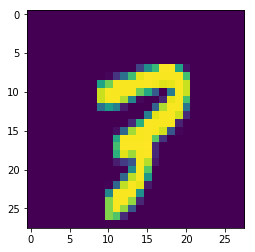

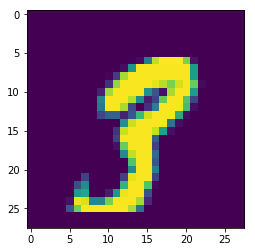

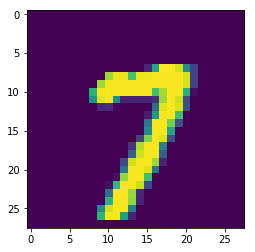

In [44]:
i = 0

plt.imshow(X_37_test[i, :, :, 0])
plt.show()
plt.imshow(X_adv[i, :, :, 0])
plt.show()
for nn_adv_k in nn_adv[i]:
    plt.imshow(X_37[nn_adv_k, :, :, 0])
    plt.show()

---

## k-NN on 1st-Layer Representation 

In [5]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, Input, Activation

inpt = Input(shape=(28, 28, 1))
l1 = Conv2D(64, (8, 8), strides=(2, 2), padding='same', activation='relu')(inpt)
l2 = Conv2D(128, (6, 6), strides=(2, 2), padding='same', activation='relu')(l1)
l3 = Conv2D(128, (5, 5), strides=(1, 1), padding='valid', activation='relu')(l2)
flat = Flatten()(l3)
l4 = Dense(10, activation=None)(flat)
out = Activation('softmax')(l4)

model = Model(inputs=inpt, outputs=out)
l1_rep = Model(inputs=inpt, outputs=l1)
l2_rep = Model(inputs=inpt, outputs=l2)
l3_rep = Model(inputs=inpt, outputs=l3)
l4_rep = Model(inputs=inpt, outputs=l4)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=128,
          epochs=15,
          verbose=1,
          validation_data=(X_test, y_test))

model.save_weights('keras_weights/mnist_cnn.h5')

model.load_weights('keras_weights/mnist_cnn.h5')
model.evaluate(X_test, y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 5s 78us/step - loss: 0.1710 - acc: 0.9490 - val_loss: 0.0559 - val_acc: 0.9825
Epoch 2/15
60000/60000 [==============================] - 4s 62us/step - loss: 0.0466 - acc: 0.9859 - val_loss: 0.0381 - val_acc: 0.9889
Epoch 3/15
60000/60000 [==============================] - 4s 62us/step - loss: 0.0326 - acc: 0.9892 - val_loss: 0.0353 - val_acc: 0.9893
Epoch 4/15
60000/60000 [==============================] - 4s 61us/step - loss: 0.0225 - acc: 0.9931 - val_loss: 0.0299 - val_acc: 0.9902
Epoch 5/15
60000/60000 [==============================] - 4s 62us/step - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0323 - val_acc: 0.9907
Epoch 6/15
60000/60000 [==============================] - 4s 61us/step - loss: 0.0134 - acc: 0.9956 - val_loss: 0.0319 - val_acc: 0.9895
Epoch 7/15
60000/60000 [==============================] - 4s 62us/step - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0434 - val_acc

[0.03731346611475783, 0.9924]

In [60]:
def get_l1(X):
    x = tf.placeholder(tf.float32, (None, 28, 28, 1))
    y = l1_rep(x)
    return sess.run(y, feed_dict={x: X})


def get_all_rep(X):
    x = tf.placeholder(tf.float32, (None, 28, 28, 1))
    
    l1 = l1_rep(x)
    out_l1 = np.zeros((len(X), ) + tuple(l1.shape[1:]))
    for i in range(int(np.ceil(len(X)/1000))):
        out_l1[i*1000 : (i + 1)*1000] = sess.run(
            l1, feed_dict={x: X[i*1000 : (i + 1)*1000]})
        
    l2 = l2_rep(x)
    out_l2 = np.zeros((len(X), ) + tuple(l2.shape[1:]))
    for i in range(int(np.ceil(len(X)/1000))):
        out_l2[i*1000 : (i + 1)*1000] = sess.run(
            l2, feed_dict={x: X[i*1000 : (i + 1)*1000]})
        
    l3 = l3_rep(x)
    out_l3 = np.zeros((len(X), ) + tuple(l3.shape[1:]))
    for i in range(int(np.ceil(len(X)/1000))):
        out_l3[i*1000 : (i + 1)*1000] = sess.run(
            l3, feed_dict={x: X[i*1000 : (i + 1)*1000]})
        
    l4 = l4_rep(x)
    out_l4 = np.zeros((len(X), ) + tuple(l4.shape[1:]))
    for i in range(int(np.ceil(len(X)/1000))):
        out_l4[i*1000 : (i + 1)*1000] = sess.run(
            l4, feed_dict={x: X[i*1000 : (i + 1)*1000]})
        
    return [out_l1, out_l2, out_l3, out_l4]

In [225]:
get_layer1 = K.function([model.input, K.learning_phase()], [model.layers[0].output])

In [74]:
X_37_l1 = get_layer1([X_37, 0])[0]
X_37_test_l1 = get_layer1([X_37_test, 0])[0]

In [76]:
k = 3
nn_l1 = find_nn(X_37_test_l1, X_37_l1, k)

In [77]:
find_acc(nn_l1, y_37_test, y_37)

0.9936211972522081


Calibrate and compute $\Omega_\lambda$

In [7]:
# Randomly chosen calibrate set 75 samples from each class
ind_cal = np.zeros((750, ), dtype=np.int32)
for i in range(10):
    ind = np.where(y_test == i)[0]
    np.random.shuffle(ind)
    ind_cal[i*75 : (i + 1)*75] = ind[:75]
ind_test = np.arange(len(X_test), dtype=np.int32)
ind_test = np.setdiff1d(ind_test, ind_cal)

In [8]:
X_cal = X_test[ind_cal]
y_cal = y_test[ind_cal]
X_test = X_test[ind_test]
y_test = y_test[ind_test]

In [61]:
rep_train = get_all_rep(X_train)
rep_test = get_all_rep(X_test)
rep_cal = get_all_rep(X_cal)

In [ ]:
# Compute Omega multiset
omega = []

for i in range(4):
    print(i)
    nn = find_nn(rep_cal[i], rep_train[i], 75)
    bincount = [np.bincount(y, minlength=10) for y in y_train[nn]]
    o_lambda = []
    for j, b in enumerate(bincount):
        print('  ' + str(j))
        label = y_cal[j]
        o_lambda.append(75 - b[label])
    omega.append(np.array(o_lambda))
omega = np.array(omega)

0
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  10
  11
  12
  13
  14
  15
  16
  17
  18
  19
  20
  21
  22
  23
  24
  25
  26
  27
  28
  29
  30
  31
  32
  33
  34
  35
  36
  37
  38
  39
  40
  41
  42
  43
  44
  45
  46
  47
  48
  49
  50
  51
  52
  53
  54
  55
  56
  57
  58
  59
  60
  61
  62
  63
  64
  65
  66
  67
  68
  69
  70
  71
  72
  73
  74
  75
  76
  77
  78
  79
  80
  81
  82
  83
  84
  85
  86
  87
  88
  89
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
  100
  101
  102
  103
  104
  105
  106
  107
  108
  109
  110
  111
  112
  113
  114
  115
  116
  117
  118
  119
  120
  121
  122
  123
  124
  125
  126
  127
  128
  129
  130
  131
  132
  133
  134
  135
  136
  137
  138
  139
  140
  141
  142
  143
  144
  145
  146
  147
  148
  149
  150
  151
  152
  153
  154
  155
  156
  157
  158
  159
  160
  161
  162
  163
  164
  165
  166
  167
  168
  169
  170
  171
  172
  173
  174
  175
  176
  177
  178
  179
  180
  181
  182
  183
  18

In [87]:
pickle.dump(omega, open("A.p", "wb"))

In [88]:
A = pickle.load(open("A.p", "rb"))

In [104]:
# Classify on test set
def omega_classify(A, rep, rep_train, y_train):
    
    alphas = []
    for i in range(4):
        nn = find_nn(rep[i], rep_train[i], 75)
        bincount = [np.bincount(y, minlength=10) for y in y_train[nn]]
        alpha = np.zeros((len(bincount), 10))
        for j, b in enumerate(bincount):
            alpha[j] = np.array([75 - b[label] for label in range(10)])
        alphas.append(alpha)
    alphas = np.array(alphas)
    return alphas, np.sum(alphas, axis=0)

In [101]:
rep_test_37 = [r[(y_test == 3) | (y_test == 7)] for r in rep_test]

In [102]:
all_bins, alphas = omega_classify(A, rep_test_37, rep_train, y_train)

IndexError: index 4 is out of bounds for axis 0 with size 4

### Attack on k=1

In [342]:
def find_nn_by_dist(Q, X, dist):
    axis = np.arange(1, Q.ndim)
    nn = []
    for i, q in enumerate(Q):
        ind = np.sum((X - q)**2, axis=axis) <= dist
        nn.append(np.where(ind)[0])
    return nn


class BaselineAttack(object):
    
    def __init__(self, sess, model, get_rep, X, X_rep, y_X, 
                 pert_norm=2, batch_size=1000, lr=1e-3, 
                 abort_early=True, init_const=1, min_dist=1,
                 pert_bound=0.3):
    
        self.sess = sess
        self.model = model
        self.X = X
        self.X_rep = X_rep
        self.y_X = y_X
        self.batch_size = batch_size
        self.abort_early = abort_early
        self.init_const = init_const
        self.min_dist = min_dist
        self.pert_norm = pert_norm
        self.pert_bound = pert_bound
        
        input_ndim = X.ndim
        input_axis = np.arange(1, input_ndim)
        input_shape = (batch_size, ) + X.shape[1:]
        rep_ndim = X_rep.ndim
        rep_axis = np.arange(1, rep_ndim)
        rep_shape = (batch_size, ) + X_rep.shape[1:]

        # Objective variable
        modifier = tf.Variable(np.zeros(input_shape), dtype=tf.float32)

        # These are variables to be more efficient in sending data to tf
        q_var = tf.Variable(np.zeros(input_shape), dtype=tf.float32, name='q_var')
        target_var = tf.Variable(np.zeros(rep_shape), dtype=tf.float32, name='target_var')
        const_var = tf.Variable(
            np.zeros(batch_size), dtype=tf.float32, name='const_var')

        # and here's what we use to assign them
        self.assign_q = tf.placeholder(tf.float32, input_shape, name='assign_q')
        self.assign_target = tf.placeholder(tf.float32, rep_shape, name='assign_target')
        self.assign_const = tf.placeholder(
            tf.float32, [batch_size], name='assign_const')

        # Clip to ensure pixel value is between 0 and 1
        self.new_q = tf.clip_by_value(q_var + modifier, 0., 1.)
        # Get reprentation tensor
        self.rep = get_rep(self.new_q)

        # L2 loss
        self.l2dist = tf.reduce_sum(tf.square(modifier), input_axis)
        dist_loss = tf.reduce_sum(tf.square(self.rep - target_var), rep_axis)
        self.dist_loss = tf.maximum(0., dist_loss - self.min_dist**2)
        
        # Setup optimizer
        start_vars = set(x.name for x in tf.global_variables())
        if pert_norm == 2:
            # For L-2 norm constraint, we use Adam optimizer with
            # a penalty term
            self.loss = tf.reduce_mean(const_var*self.dist_loss + self.l2dist)
            optimizer = tf.train.AdamOptimizer(lr)
            self.train_step = optimizer.minimize(self.loss, var_list=[modifier])
        elif pert_norm == np.inf:
            # For L-inf norm constraint, we use L-BFGS-B optimizer 
            # to provide correct bound, optimizer setup is moved to attack()
            self.loss = tf.reduce_mean(self.dist_loss)
            self.modifier = modifier
        else:
            raise ValueError('Invalid choice for perturbation norm!')
            
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        self.setup = []
        self.setup.append(q_var.assign(self.assign_q))
        self.setup.append(target_var.assign(self.assign_target))
        self.setup.append(const_var.assign(self.assign_const))
        self.init = tf.variables_initializer(var_list=[modifier] + new_vars)
        
    def attack(self, Q, Q_rep, y_Q, const=1, bin_search_steps=5, max_iter=200):
        r = []
        for i in range(0, len(Q), self.batch_size):
            print("Running Baseline Attack on instance {} of {}".format(
                i, len(Q)))
            r.extend(self.attack_batch(Q[i:i + self.batch_size],
                                       Q_rep[i:i + self.batch_size],
                                       y_Q[i:i + self.batch_size],
                                       const=const,
                                       bin_search_steps=bin_search_steps,
                                       max_iter=max_iter))
        return np.array(r)

        
    def attack_batch(self, Q, Q_rep, y_Q, const=1, bin_search_steps=5, max_iter=200):   
        
        # Find closest rep of different class
        print("  Finding nn representation as target...")
        nn = find_nn_diff_class(Q_rep, y_Q, self.X_rep, self.y_X, 1)
        target_rep = np.squeeze(self.X_rep[nn])
        # Find nn to target rep to save nn search time during optimization
        # check_rep = find_nn(target_rep, self.X_rep, 100)
        
        # ============ Optimizing with L-inf norm constraints =========== #
        # L-BFGS-B optimizer only needs to be called once
        if self.pert_norm == np.inf:
            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            target_rep_batch = target_rep[:self.batch_size]
            const = np.ones(self.batch_size) * self.init_const
            
            # Set the variables so that we don't have to send them over again
            self.sess.run(
                self.setup, {
                    self.assign_q: Q_batch,
                    self.assign_target: target_rep_batch,
                    self.assign_const: const
                })
            
            # Set up variables bound and optimizer
            upper_bound = np.minimum(self.pert_bound, 1 - Q_batch)
            lower_bound = np.maximum(-self.pert_bound, -Q_batch)
            var_to_bounds = {self.modifier: (lower_bound, upper_bound)}
            optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                self.loss, 
                var_list=[self.modifier], 
                var_to_bounds=var_to_bounds, 
                method='L-BFGS-B')
            
            # Call optimizer
            optimizer.minimize(self.sess)
            return self.sess.run(self.new_q)
            
        # ============= Optimizing with L2 norm constraints ============ #
        o_bestl2 = [1e9] * self.batch_size
        o_bestadv = np.zeros_like(Q[:self.batch_size])
        
        # Set the lower and upper bounds
        lower_bound = np.zeros(self.batch_size)
        const = np.ones(self.batch_size) * self.init_const
        upper_bound = np.ones(self.batch_size) * 1e9
       
        for outer_step in range(bin_search_steps):

            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            target_rep_batch = target_rep[:self.batch_size]
            
            bestl2 = [1e9] * self.batch_size
            bestadv = np.zeros_like(Q_batch)
            print("  Binary search step {} of {}".format(
                outer_step, bin_search_steps))

            # Set the variables so that we don't have to send them over again
            self.sess.run(
                self.setup, {
                    self.assign_q: Q_batch,
                    self.assign_target: target_rep_batch,
                    self.assign_const: const
                })

            prev = 1e6
            for iteration in range(max_iter):
                # Take one step in optimization
                _, l, l2s, dls, reps, qs = self.sess.run([self.train_step, 
                                                          self.loss, 
                                                          self.l2dist,
                                                          self.dist_loss,
                                                          self.rep, 
                                                          self.new_q])
                
                if iteration % ((max_iter // 10) or 1) == 0:
                    print(("    Iteration {} of {}: loss={:.3g} l2={:.3g}").format(
                        iteration, max_iter, l, np.mean(l2s)))
                
                # Abort early if stop improving
                if self.abort_early and iteration % ((max_iter // 10) or 1) == 0:
                    if l > prev * .9999:
                        print("    Failed to make progress; stop early")
                        break
                    prev = l
                
                # Check termination condition
                # nn = find_nn(reps, self.X_rep, 1)
                # y_pred = classify(nn, self.y_X)
                # suc_ind = np.where(y_pred != y_Q)[0]
                suc_ind = np.where(dls <= 1e-3)[0]
                for ind in suc_ind:
                    if l2s[ind] < bestl2[ind]:
                        bestl2[ind] = l2s[ind]
                        bestadv[ind] = qs[ind]                    

                        
            # Adjust const according to results
            for e in range(self.batch_size):
                if bestl2[e] < 1e9:
                    # Success, divide const by two
                    upper_bound[e] = min(upper_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    if bestl2[e] < o_bestl2[e]:
                        o_bestl2[e] = bestl2[e]
                        o_bestadv[e] = bestadv[e]
                else:
                    # Failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        const[e] *= 10
                        
        return o_bestadv

# picking closest rep is not efficient

# implement random restart

# Implement outer loop for baseline attack to bin search min_dist

In [343]:
baseline = BaselineAttack(sess, model, l1_rep, 
                          X_37, X_37_l1, y_37, 
                          pert_norm=2,
                          batch_size=5, 
                          lr=1e-2, 
                          abort_early=True,
                          init_const=1, 
                          min_dist=5)

In [344]:
X_adv = baseline.attack(X_37_test[:5], X_37_test_l1[:5], y_37_test[:5], 
                        const=1, 
                        bin_search_steps=5, 
                        max_iter=500)

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
  Binary search step 0 of 5
    Iteration 0 of 500: loss=101 l2=0
    Iteration 50 of 500: loss=25.1 l2=12.5
    Iteration 100 of 500: loss=18.8 l2=15.6
    Iteration 150 of 500: loss=17.5 l2=17.5
    Iteration 200 of 500: loss=17.4 l2=17.3
    Iteration 250 of 500: loss=17.4 l2=17.3
    Failed to make progress; stop early
  Binary search step 1 of 5
    Iteration 0 of 500: loss=50.5 l2=0
    Iteration 50 of 500: loss=17.7 l2=9.08
    Iteration 100 of 500: loss=16.5 l2=10.8
    Iteration 150 of 500: loss=16.4 l2=11.2
    Iteration 200 of 500: loss=16.4 l2=11.2
    Failed to make progress; stop early
  Binary search step 2 of 5
    Iteration 0 of 500: loss=67 l2=0
    Iteration 50 of 500: loss=21.2 l2=10.1
    Iteration 100 of 500: loss=17.8 l2=13.5
    Iteration 150 of 500: loss=17.3 l2=14.6
    Iteration 200 of 500: loss=17.2 l2=14.7
    Iteration 250 of 500: loss=17.2 l2=14.7
    Iteration 300 of 500:

In [300]:
baseline = BaselineAttack(sess, model, l1_rep, 
                          X_37, X_37_l1, y_37, 
                          pert_norm=np.inf,
                          batch_size=5, 
                          lr=1e-2, 
                          abort_early=True,
                          init_const=1, 
                          min_dist=1,
                          pert_bound=0.3)

In [288]:
X_adv = baseline.attack(X_37_test[:5], X_37_test_l1[:5], y_37_test[:5])

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 37.350212
  Number of iterations: 87
  Number of functions evaluations: 107


In [301]:
np.max(np.abs(X_adv - X_37_test[:5]), axis=(1, 2, 3))

array([0.99598867, 0.9355945 , 0.99215686, 0.99607843, 0.99607843])

In [302]:
X_adv.max()

1.0

In [345]:
X_adv_l1 = get_l1(X_adv)

In [235]:
nn = find_nn_diff_class(X_37_test_l1[:5], y_37_test[:5], X_37_l1, y_37, 1)
target_rep = np.squeeze(X_37_l1[nn])

In [346]:
np.sum((X_adv_l1 - target_rep)**2, axis=(1, 2, 3))

array([24.998856, 25.000402, 24.990017, 24.998325, 24.997124],
      dtype=float32)

In [358]:
nn = find_nn(X_adv_l1, X_37_l1, 1)
nn_rep = np.squeeze(X_37_l1[nn])

In [351]:
np.sum((X_adv_l1 - nn_rep)**2, axis=(1, 2, 3))

array([24.998856, 25.000402, 24.990017, 24.998325, 24.997124],
      dtype=float32)

In [361]:
nn = find_nn(X_adv_l1, X_37_l1, 5)
nn5_rep = np.squeeze(X_37_l1[nn])

In [369]:
np.sum((X_adv_l1[2] - nn5_rep[2])**2, axis=(1, 2, 3))

array([24.990017, 78.16258 , 82.02327 , 85.29616 , 87.17379 ],
      dtype=float32)

In [367]:
y_37[nn]

array([[3, 7, 7, 7, 7],
       [3, 7, 7, 7, 7],
       [7, 7, 7, 7, 7],
       [3, 7, 7, 7, 7],
       [7, 7, 7, 7, 7]], dtype=uint8)

In [356]:
np.sum((X_adv_l1 - nn5_rep)**2, axis=(2, 3, 4))

array([[ 24.998856,  86.93029 , 144.90533 ,  72.729675,  82.97179 ],
       [110.412735,  40.690693, 219.753   , 143.90091 , 136.95364 ],
       [141.7977  ,  96.08033 ,  82.02327 , 136.07146 ,  95.27412 ],
       [111.96751 , 137.09079 , 133.85623 ,  44.808296, 157.14606 ],
       [ 95.179596, 115.18753 , 151.34016 , 105.466385,  58.554752]],
      dtype=float32)

In [341]:
np.sum((X_37_test_l1[:5] - target_rep)**2, axis=(1, 2, 3))

array([102.87587, 112.11878, 200.72572, 100.779  , 113.49605],
      dtype=float32)

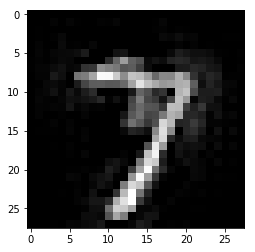

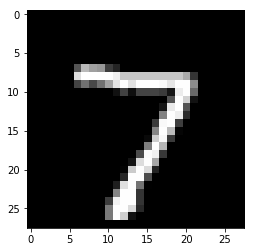

In [366]:
i = 0
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()

---
